<a href="https://colab.research.google.com/github/Sayandan141/BloomIQ/blob/main/sentiment_analysis(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy pandas matplotlib seaborn nltk wordcloud xgboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
import pandas as pd

 # **Corrected URL (Raw file URL)**
url = "https://raw.githubusercontent.com/sharmaroshan/Amazon-Alexa-Reviews/c57f411113457d7ce3522a8181bde9bd6bf3d282/amazon_alexa.tsv"

data = pd.read_csv(url, delimiter="\t", quoting=3)

print(f"Dataset shape: {data.shape}")
print(f"Dataset columns: {data.columns}")

Dataset shape: (3150, 5)
Dataset columns: Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')


In [4]:
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [5]:
data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [6]:
data[data['verified_reviews'].isna()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [7]:


#creating a new colun length that will contain the length of thr string in 'verified_reviews' column

# Convert the 'verified_reviews' column to string type before applying len()
data['length'] = data['verified_reviews'].astype(str).apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"""Sometimes while playing a game, you can answe...",1,197
3,5,31-Jul-18,Charcoal Fabric,"""I have had a lot of fun with this thing. My 4...",1,174
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [8]:
#randomly checking for 10th record

print(f"'verified_reviews' common value:{data.iloc[10]['verified_reviews']}")
print(f"'rating' common value:{data.iloc[10]['rating']}")
print(f"'length' common value:{data.iloc[10]['length']}")

'verified_reviews' common value:"I sent it to my 85 year old Dad, and he talks to it constantly."
'rating' common value:5
'length' common value:65


In [9]:
data.dtypes
print(f"rating value count: \n{data['rating'].value_counts()}")


rating value count: 
rating
5    2286
4     455
1     161
3     152
2      96
Name: count, dtype: int64


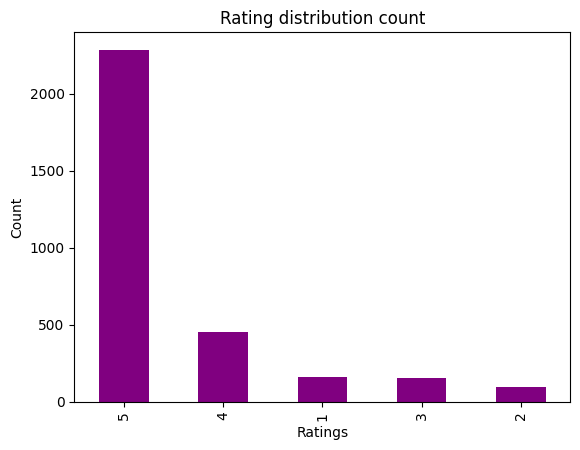

In [10]:
data['rating'].value_counts().plot.bar(color= 'purple')
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

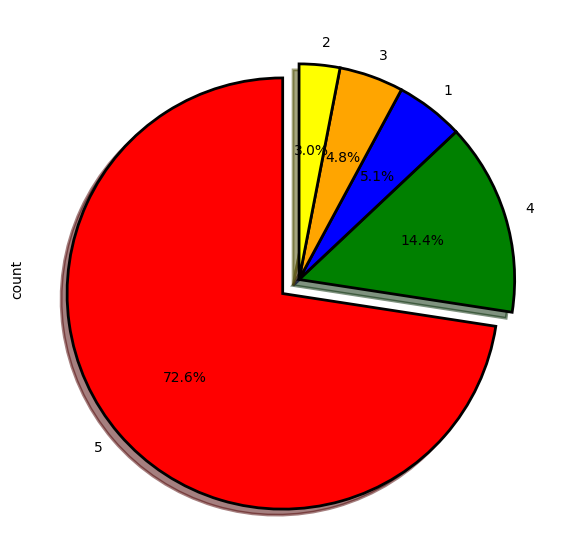

In [11]:
fig= plt.figure(figsize=(7,7))
colors= ('red','green','blue','orange','yellow')
wp={'linewidth':2,'edgecolor':'black'}
tags= data['rating'].value_counts()/data.shape[0]
explode=(0.1,0,0,0,0)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, ax=fig.add_subplot(1,1,1))
from io import BytesIO
graph= BytesIO()
fig.savefig(graph, format='png')

In [12]:
print(f"feedback value count: \n{data['feedback'].value_counts()}")

feedback value count: 
feedback
1    2893
0     257
Name: count, dtype: int64


In [13]:
#there are 2 distinct values of 'feedback' present - 0 and 1.
review_0=data[data['feedback']==0].iloc[1]['verified_reviews']
review_1=data[data['feedback']==1].iloc[1]['verified_reviews']
print(review_0)
print(review_1)

Sound is terrible if u want good music too get a bose
Loved it!


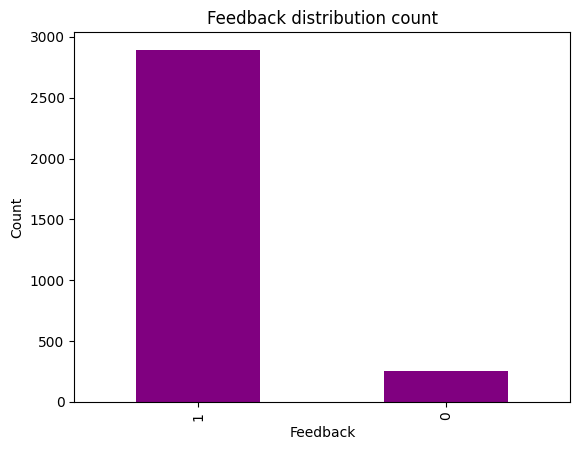

In [14]:
data['feedback'].value_counts().plot.bar(color= 'purple')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

#the rating values for different values of 'feedback'
data.groupby('feedback')['rating'].value_counts()

[Text(0.5, 1.0, 'Length distribution')]

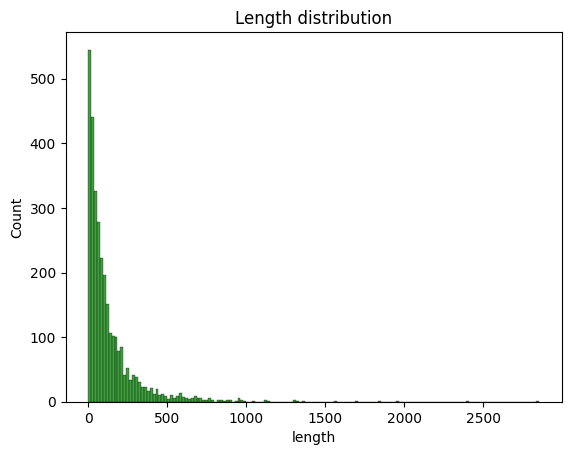

In [15]:
#length analysis for full dataset
sns.histplot(data['length'],color='green').set(title='Length distribution')

In [16]:
data.groupby('variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


In [17]:
cv= CountVectorizer(stop_words = 'english')
# Replace NaN values in 'verified_reviews' with empty strings
data['verified_reviews'] = data['verified_reviews'].fillna('')
words = cv.fit_transform(data.verified_reviews)

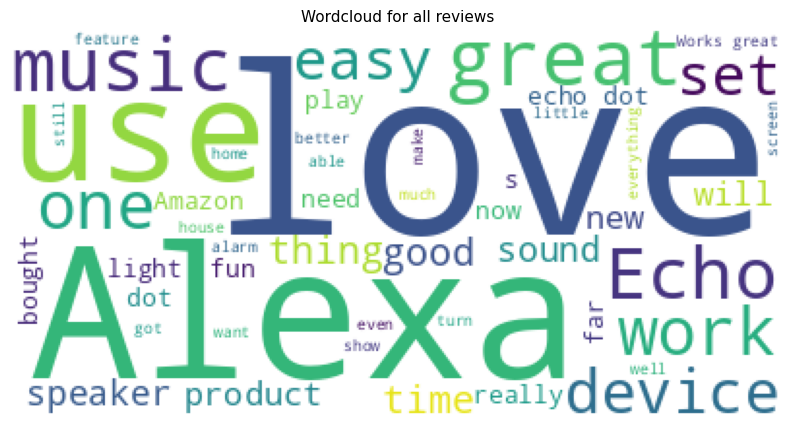

In [18]:
#combine all reviews
reviews= " ".join([review for review in data['verified_reviews']])
#initiate wordvloud object
wc = WordCloud(background_color= 'white',max_words= 50)

#generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=11)
plt.axis('off')
plt.show()


In [19]:
#combine all the reviews for each feedback category and splitting them into individual word
neg_reviews= " ".join([review for review in data[data['feedback']==0]['verified_reviews']])
pos_reviews= " ".join([review for review in data[data['feedback']==1]['verified_reviews']])

neg_reviews = neg_reviews.lower().split()
pos_reviews = pos_reviews.lower().split()

#finding words from reviews which are present to that feedback categoty only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_positive = [x for x in pos_reviews if x not in neg_reviews]

unique_negative= " ".join(unique_negative)
unique_positive= " ".join(unique_positive)

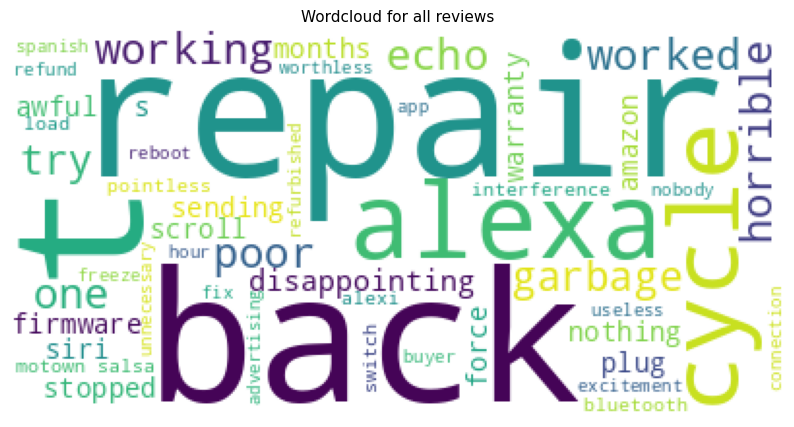

In [20]:
#initiate wordvloud object
wc = WordCloud(background_color= 'white',max_words= 50)

#generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for all reviews', fontsize=11)
plt.axis('off')
plt.show()

data preprocessing and modelling'

In [21]:
corpus = []
stemmer = PorterStemmer()
for i in range(0,data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['verified_reviews'])
  review = review.lower()
  review = review.split()
  review = [stemmer.stem(word) for word in review if not word in set(STOPWORDS)]
  review = ' '.join(review)
  corpus.append(review)

In [22]:
cv = CountVectorizer(max_features = 2000)
#storing independent and dependent variables in x and y
X=cv.fit_transform(corpus).toarray()
y=data['feedback'].values

In [23]:
import os

# Create the 'Models' directory if it doesn't exist
os.makedirs('Models', exist_ok=True)

# Now you can save the file
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

In [24]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (3150, 2000)
y shape: (3150,)


In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (2205, 2000)
X_test shape: (945, 2000)
Y_train shape: (2205,)
Y_test shape: (945,)


In [26]:
print(f"X train max value:{X_train.max()}")
print(f"X train min value:{X_train.min()}")
print(f"X test max value:{X_test.max()}")
print(f"X test min value:{X_test.min()}")

X train max value:12
X train min value:0
X test max value:10
X test min value:0


In [27]:
scalar = MinMaxScaler()
X_train_scl = scalar.fit_transform(X_train)
X_test_scl = scalar.transform(X_test)

In [28]:
#saving the scalar model
pickle.dump(scalar, open('Models/scalar.pkl', 'wb'))


Random-Forest Classifier

In [29]:
#fitting scaled X_train and y_train on Random Forest Classifier
model_rf= RandomForestClassifier()
model_rf.fit(X_train_scl,Y_train)

RandomForestClassifier()

In [30]:
#Accuracy of model
print(f"Accuracy of model:" ,model_rf.score(X_test_scl,Y_test))
print(f"Training Accuracy:",model_rf.score(X_train_scl,Y_train))

Accuracy of model: 0.9375661375661376
Training Accuracy: 0.9931972789115646


In [31]:
#predicting the dataset
y_preds=model_rf.predict(X_test_scl)
#confusion Matrix
cm = confusion_matrix(Y_test, y_preds)
print(cm)

[[ 24  51]
 [  8 862]]


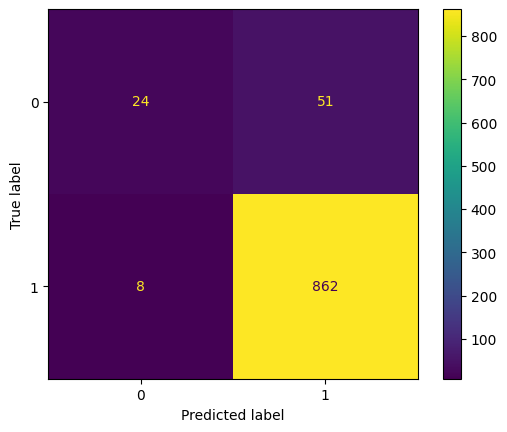

In [32]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()